In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

In [222]:
# read in deals data, convert closed_won_date to datetime object
deal = pd.read_csv('C:/Users/dselw/Desktop/Block_Renovation_Technical/deal.csv')
deal['closed_won_date'] = pd.to_datetime(deal['closed_won_date'])
deal.head()

,deal_id,handoff_date,pitched_proposal_date,closed_won_date,deal_value_usd
0,304185249,NaN,NaN,2018-07-17,53454.0
1,304185521,NaN,NaN,NaT,NaN
2,304186077,NaN,NaN,2018-07-16,41473.0
3,304187429,NaN,NaN,NaT,NaN
4,304187641,NaN,NaN,NaT,NaN


In [223]:
# get only closed deals i.e. deals that have a populated closed_won_date
closed_deal = deal[pd.notnull(deal['closed_won_date'])]

# drop unnecessary columns and duplicates, rename and sort by closed_won_date, reset index
closed_deal.drop(['handoff_date', 'pitched_proposal_date'], axis=1, inplace=True)
closed_deal.drop_duplicates(inplace=True)
closed_deal.rename({'closed_won_date':'closed_date'}, axis=1, inplace=True)
closed_deal.sort_values('closed_date', inplace=True)
closed_deal.reset_index(drop=True, inplace=True)
closed_deal.head()

C:\Users\dselw\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\dselw\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dselw\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\dselw\anaconda3\lib\site-packages\ipykernel_launcher.

,deal_id,closed_date,deal_value_usd
0,332240473,2018-06-01,41014.0
1,305224570,2018-06-12,34885.0
2,823622344,2018-06-13,18537.0
3,332250072,2018-06-15,28096.0
4,332250337,2018-06-15,46960.0


In [224]:
# function to calculate completion date as 6 months after closed_date
def completion_date(close_date):
    completion_date = close_date + datetime.timedelta(math.ceil(6 * 365/12))
    return completion_date

# function to calculate halfway date between closed_date and completion_date
def halfway_date(close_date):
    comp_date = completion_date(close_date)
    halfway_date = close_date + datetime.timedelta(round((comp_date-close_date).days/2.0))
    return halfway_date

In [226]:
# create new columns that consist of halfway and completion dates for each deal
closed_deal['halfway_date'] = closed_deal['closed_date'].apply(halfway_date)
closed_deal['completion_date'] = closed_deal['closed_date'].apply(completion_date)

# re-order columns
closed_deal = closed_deal[['deal_id', 'deal_value_usd', 'closed_date', 'halfway_date', 'completion_date']]

closed_deal.head()

C:\Users\dselw\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dselw\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,deal_id,deal_value_usd,closed_date,halfway_date,completion_date
0,332240473,41014.0,2018-06-01,2018-09-01,2018-12-01
1,305224570,34885.0,2018-06-12,2018-09-12,2018-12-12
2,823622344,18537.0,2018-06-13,2018-09-13,2018-12-13
3,332250072,28096.0,2018-06-15,2018-09-15,2018-12-15
4,332250337,46960.0,2018-06-15,2018-09-15,2018-12-15


In [227]:
# create dataframe with all dates between the earliest deal close and 6 months after the most recently closed deal (aka completion date), inclusive
rev_recog = pd.DataFrame(pd.date_range(min(closed_deal['closed_date']), max(closed_deal['completion_date'])), columns=['Date'])
rev_recog.head()

,Date
0,2018-06-01
1,2018-06-02
2,2018-06-03
3,2018-06-04
4,2018-06-05


In [228]:
# function to calculate revenue recognized on a given date
def revenue_recognized(date):
    
    # boolean arrays that are True if closed/halfway/completion date is equal to given date, False otherwise
    if_closed_date = (closed_deal['closed_date'] == date)
    if_halfway_date = (closed_deal['halfway_date'] == date)
    if_completion_date = (closed_deal['completion_date'] == date)
    
    # for given day, calculate revenue recognized that day as sum of revenue earned at close, halfway, and completion
    revenue = 0.0
    revenue += 0.2 * sum(closed_deal['deal_value_usd'] * if_closed_date)
    revenue += 0.4 * sum(closed_deal['deal_value_usd'] * if_halfway_date)
    revenue += 0.4 * sum(closed_deal['deal_value_usd'] * if_completion_date)
    
    return revenue

# function to convert date to YYYY-MM string format
def get_month(date):
    return date.strftime("%Y-%m")

In [229]:
# create columns for month of each data and revenue recognized on each date
rev_recog['Month'] = rev_recog['Date'].apply(get_month)
rev_recog['Revenue Recognized'] = rev_recog['Date'].apply(revenue_recognized)
rev_recog.head()

,Date,Month,Revenue Recognized
0,2018-06-01,2018-06,8202.8
1,2018-06-02,2018-06,0.0
2,2018-06-03,2018-06,0.0
3,2018-06-04,2018-06,0.0
4,2018-06-05,2018-06,0.0


In [230]:
# group the dataframe by Month, summing the revenue recognized and thereby getting revenue recognized per month
monthly_revenue = rev_recog.groupby(['Month'], as_index=False).sum()

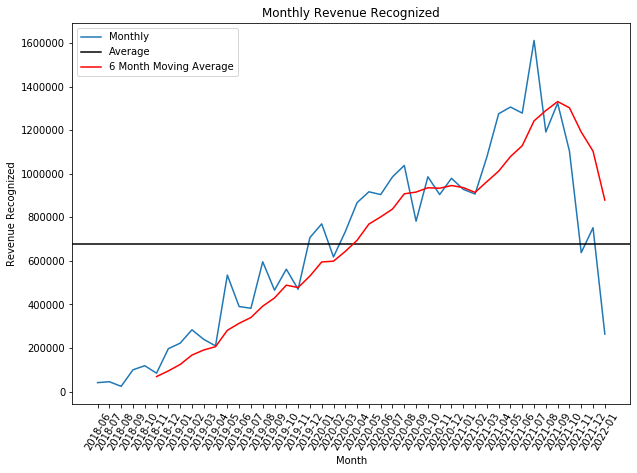

In [259]:
# plot Revenue Recognized vs Month, average, moving average
plt.plot(monthly_revenue['Month'], monthly_revenue['Revenue Recognized'], label='Monthly')
plt.axhline(np.mean(monthly_revenue['Revenue Recognized']), color='black', label='Average')

num_months = 6
plt.plot(monthly_revenue['Revenue Recognized'].rolling(num_months).mean(), color='red', label= str(num_months) + ' Month Moving Average')

plt.xlabel('Month')
plt.ylabel('Revenue Recognized')
plt.title('Monthly Revenue Recognized')

plt.legend()

plt.rcParams['figure.figsize'] = [10, 7]
plt.xticks(rotation=60)

plt.show()

In [246]:
print('Date of last closed deal: ' + max(closed_deal['closed_date']).strftime('%Y-%m-%d'))

revenue_argmax = monthly_revenue['Revenue Recognized'].argmax()
print('Month with highest revenue recognized: ' + monthly_revenue.iloc[revenue_argmax]['Month'])
print('Revenue recognized in ' + monthly_revenue.iloc[revenue_argmax]['Month'] + ': ' + str(round(monthly_revenue.iloc[revenue_argmax]['Revenue Recognized'], 2)))
print('Average revenue recognized per month: ' + str(round(np.mean(monthly_revenue['Revenue Recognized']),2)))

Date of last closed deal: 2021-07-13
Month with highest revenue recognized: 2021-07
Revenue recognized in 2021-07: 1613284.4
Average revenue recognized per month: 678092.25
